In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
from google.colab.patches import cv2_imshow
from imutils.video import VideoStream
import time
import sys

np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [4]:
DATA_DIR = '/content/drive/MyDrive/New Masks Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'Validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Test')


In [5]:
IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['Non Mask', 'Mask']


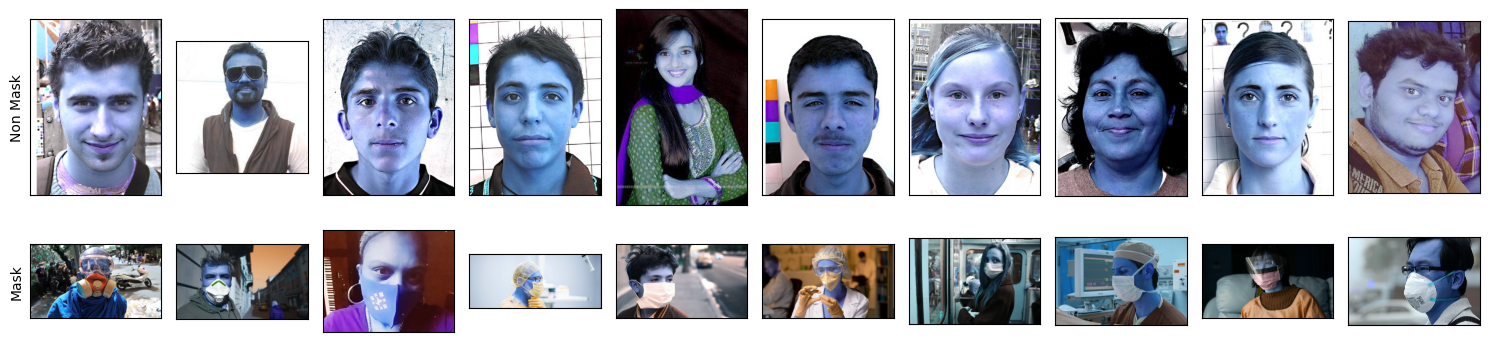

In [6]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [7]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) # 'E:/DATASETS/classification/Face Mask Dataset/train/WithMask'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 300/300 [00:05<00:00, 53.54it/s]

600


In [8]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|██████████| 153/153 [00:06<00:00, 24.01it/s]

306


In [9]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████| 57/57 [00:44<00:00,  1.27it/s]

107


In [10]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")


X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train= (600, 227, 227, 3) Y_train= (600,)
X_valid= (306, 227, 227, 3) Y_valid= (306,)
X_test= (107, 227, 227, 3) Y_test= (107,)


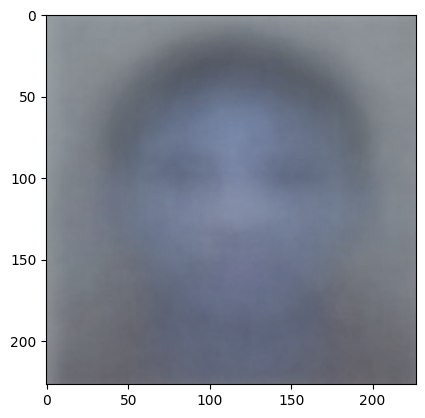

In [11]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [12]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

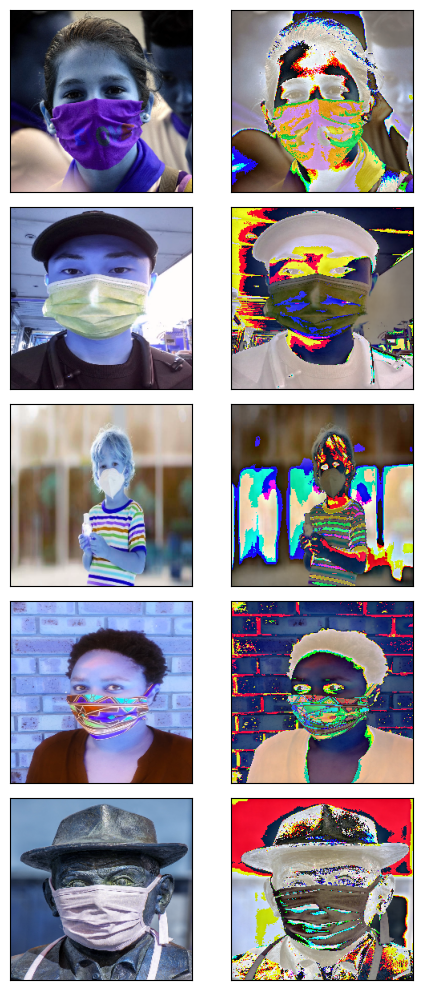

In [13]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [14]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [15]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
model.fit(x=X_train_norm, y=Y_train, epochs=20, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/20
19/19 [==============================] - 17s 166ms/step - loss: 2.0532 - accuracy: 0.7267 - val_loss: 856.6723 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 1s 55ms/step - loss: 0.6915 - accuracy: 0.8417 - val_loss: 306.1731 - val_accuracy: 0.5163
Epoch 3/20
19/19 [==============================] - 1s 61ms/step - loss: 0.3871 - accuracy: 0.8867 - val_loss: 65.4456 - val_accuracy: 0.5915
Epoch 4/20
19/19 [==============================] - 1s 49ms/step - loss: 0.4045 - accuracy: 0.8783 - val_loss: 12.1790 - val_accuracy: 0.6993
Epoch 5/20
19/19 [==============================] - 1s 47ms/step - loss: 0.3148 - accuracy: 0.8967 - val_loss: 4.0159 - val_accuracy: 0.7647
Epoch 6/20
19/19 [==============================] - 1s 47ms/step - loss: 0.2899 - accuracy: 0.9033 - val_loss: 5.6490 - val_accuracy: 0.7810
Epoch 7/20
19/19 [==============================] - 1s 48ms/step - loss: 0.2701 - accuracy: 0.9000 - val_loss: 1.3797 - val_accuracy: 0.8170
Epoch

In [17]:
predictions = model.predict(X_test)

predict = []

for i  in range(len(predictions)):
  if predictions[i][0]>0.5:
    predict.append(1)
  else:
    predict.append(0)

4/4 [==============================] - 1s 122ms/step


In [18]:
predictions = model.predict(X_test)
predictions

4/4 [==============================] - 0s 19ms/step


array([[4.52050983e-08, 1.00000000e+00],
       [1.00000000e+00, 1.08168791e-13],
       [1.00000000e+00, 3.71798495e-17],
       [1.00000000e+00, 8.98187560e-24],
       [4.73792940e-01, 5.26207089e-01],
       [9.99999881e-01, 1.78330339e-07],
       [1.00000000e+00, 7.96979085e-20],
       [9.99506235e-01, 4.93774132e-04],
       [1.00000000e+00, 3.98486435e-08],
       [9.99999166e-01, 8.86958560e-07],
       [1.00000000e+00, 6.11911001e-15],
       [1.00000000e+00, 3.47388942e-20],
       [9.99998569e-01, 1.40329450e-06],
       [9.99999881e-01, 6.47908678e-08],
       [1.00000000e+00, 6.08399053e-10],
       [1.00000000e+00, 1.18871327e-21],
       [1.00000000e+00, 1.62594049e-10],
       [1.00000000e+00, 1.39970921e-17],
       [1.00000000e+00, 1.04006685e-20],
       [1.00000000e+00, 1.22945057e-12],
       [1.00000000e+00, 1.12930698e-09],
       [1.00000000e+00, 1.11811904e-09],
       [1.00000000e+00, 6.08399053e-10],
       [1.00000000e+00, 7.71495951e-19],
       [9.999955

In [19]:
pd.DataFrame(confusion_matrix(Y_test,predict), columns = ["Mask", "No Mask"], index = ["Mask","No Mask"])

,Mask,No Mask
Mask,0,50
No Mask,6,51


In [20]:
model_name = '/content/drive/MyDrive/Colab Notebooks/mask_detect_rat.h5'
tf.keras.models.save_model(model,model_name)